[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/uwsampl/tutorial/blob/master/notebook/04b_TVM_Tutorial_VTA_ResNet.ipynb)

Please run the following block to ensure TVM is setup for this notebook, each notebook may have its own runtime.


Deploy Pretrained ResNet Model from MxNet on VTA
================================================
**Author**: [Thierry Moreau](https://homes.cs.washington.edu/~moreau/)

This tutorial provides an end-to-end demo, on how to run ResNet-18 inference
onto the VTA accelerator design to perform ImageNet classification tasks.
It showcases Relay as a front end compiler that can perform quantization (VTA only supports int8/32 inference) as well as graph packing (in order to enable tensorization in the core) to massage the compute graph for the hardware target.


Import packages
--------------------

In [1]:
from __future__ import absolute_import, print_function

import argparse, json, os, requests, time
from io import BytesIO
from os.path import join, isfile
from PIL import Image

from mxnet.gluon.model_zoo import vision
import numpy as np
from matplotlib import pyplot as plt

import tvm
from tvm import te
from tvm import rpc, autotvm, relay
from tvm.contrib import graph_executor, utils, download, graph_runtime
from tvm.contrib.debugger import debug_executor
from tvm.relay import transform

import vta
from vta.testing import simulator
from vta.top import graph_pack

# Make sure that TVM was compiled with RPC=1
assert tvm.runtime.enabled("rpc")

initialized module tvm.runtime._ffi_api
initialized module tvm.runtime._ffi_node_api
initialized module tvm.runtime.profiling
initialized module tvm.ir._ffi_api
initialized module tvm.ir._ffi_transform_api
initialized module tvm.ir.diagnostics._ffi_api
Registering function:diagnostics.override_renderer
initialized module tvm.tir._ffi_api
Registering function:tvm.default_trace_action
initialized module tvm.tir.schedule._ffi_api_schedule
initialized module tvm.tir.transform._ffi_api
initialized module tvm.tir.analysis._ffi_api
initialized module tvm.target._ffi_api
Registering function:target._load_config_dict
initialized module tvm.te._ffi_api
initialized module tvm.te.schedule
initialized module tvm.arith._ffi_api
initialized module tvm.te.hybrid
initialized module tvm.parser._ffi_api
initialized module tvm.support
Registering function:tvm_callback_rocm_link
Registering function:tvm_callback_rocm_bitcode_path
Registering function:tvm_callback_libdevice_path
Registering function:tvm_cal

Define the platform and model targets
-------------------------------------
Execute on CPU vs. VTA, and define the model.



In [2]:
# Load VTA parameters from the vta/config/vta_config.json file
env = vta.get_env()
print(env.TARGET)

# Set device=arm_cpu to run inference on the CPU
# or device=vta to run inference on the FPGA.
device = "vta"
target = env.target if device == "vta" else env.target_vta_cpu

# Dictionary lookup for when to start/end bit packing
pack_dict = {
    "resnet18_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet34_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet34_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet50_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet101_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
}


# Name of Gluon model to compile
model = "resnet18_v1"

de10pro


Obtain an execution remote
---------------------------------
When target is `pynq`, reconfigure FPGA and runtime.
Otherwise, if target is `sim`, execute locally.



In [3]:
if env.TARGET != "sim":
    
    # Get remote to board
    device_host = os.environ.get("VTA_RPC_HOST", "192.168.101.199")
    device_port = int(os.environ.get("VTA_RPC_PORT", "9091"))
    remote = rpc.connect(device_host, device_port)

    # Reconfigure the JIT runtime and FPGA.
    # You can program the FPGA with your own custom bitstream
    # by passing the path to the bitstream file instead of None.
    vta.reconfig_runtime(remote)
    vta.program_fpga(remote, bitstream=None)
    print(remote)

# In simulation mode, host the RPC server locally.
else:
    remote = rpc.LocalSession()

# Get execution context from remote
ctx = remote.ext_dev(0) if device == "vta" else remote.cpu(0)

TVMModGetFunction:tvm.contrib.vta.reconfig_runtime
TVMModGetFunction:tvm.contrib.vta.init
TVMModGetFunction:tvm.rpc.server.upload


Build the inference graph runtime
---------------------------------
Grab ResNet-18 model from Gluon model zoo and compile with Relay.
The compilation steps are:
   1. Front end translation from MxNet into Relay module.
   2. Apply 8-bit quantization: here we skip the first conv layer,
      and dense layer which will both be executed in fp32 on the CPU.
   3. Perform graph packing to alter the data layout for tensorization.
   4. Perform constant folding to reduce number of operators (e.g. eliminate batch norm multiply).
   5. Perform relay build to object file.
   6. Load the object file onto remote (FPGA device).
   7. Generate graph runtime, `m`.


In [4]:
# Populate the shape and data type dictionary for ResNet input
dtype_dict = {"data": 'float32'}
shape_dict = {"data": (env.BATCH, 3, 224, 224)}

# Get off the shelf gluon model, and convert to relay
gluon_model = vision.get_model(model, pretrained=True)

# Measure build start time
build_start = time.time()

# Start front end compilation
mod, params = relay.frontend.from_mxnet(gluon_model, shape_dict)

# Update shape and type dictionary
shape_dict.update({k: v.shape for k, v in params.items()})
dtype_dict.update({k: str(v.dtype) for k, v in params.items()})

# Print the off the shelf model
print(mod)

def @main(%data: Tensor[(1, 3, 224, 224), float32], %resnetv10_conv0_weight: Tensor[(64, 3, 7, 7), float32], %resnetv10_batchnorm0_gamma: Tensor[(64), float32], %resnetv10_batchnorm0_beta: Tensor[(64), float32], %resnetv10_batchnorm0_running_mean: Tensor[(64), float32], %resnetv10_batchnorm0_running_var: Tensor[(64), float32], %resnetv10_stage1_conv0_weight: Tensor[(64, 64, 3, 3), float32], %resnetv10_stage1_batchnorm0_gamma: Tensor[(64), float32], %resnetv10_stage1_batchnorm0_beta: Tensor[(64), float32], %resnetv10_stage1_batchnorm0_running_mean: Tensor[(64), float32], %resnetv10_stage1_batchnorm0_running_var: Tensor[(64), float32], %resnetv10_stage1_conv1_weight: Tensor[(64, 64, 3, 3), float32], %resnetv10_stage1_batchnorm1_gamma: Tensor[(64), float32], %resnetv10_stage1_batchnorm1_beta: Tensor[(64), float32], %resnetv10_stage1_batchnorm1_running_mean: Tensor[(64), float32], %resnetv10_stage1_batchnorm1_running_var: Tensor[(64), float32], %resnetv10_stage1_conv2_weight: Tensor[(64, 6

In [5]:
if target.device_name == "vta":
        # Perform quantization in Relay
        # Note: We set opt_level to 3 in order to fold batch norm
        with tvm.transform.PassContext(opt_level=3):
            with relay.quantize.qconfig(global_scale=8.0, skip_conv_layers=[0]):
                mod = relay.quantize.quantize(mod, params=params)
            # Perform graph packing and constant folding for VTA target
            assert env.BLOCK_IN == env.BLOCK_OUT
            # do device annotation if target is intelfocl or sim
            relay_prog = graph_pack(
                mod["main"],
                env.BATCH,
                env.BLOCK_OUT,
                env.WGT_WIDTH,
                start_name=pack_dict[model][0],
                stop_name=pack_dict[model][1],
                device_annot=(env.TARGET == "intelfocl" or env.TARGET == "sim"),
            )
else:
        relay_prog = mod["main"]


In [6]:
# Compile Relay program with AlterOpLayout disabled
if target.device_name != "vta":
    with tvm.transform.PassContext(opt_level=3, disabled_pass={"AlterOpLayout"}):
        graph, lib, params = relay.build(
            relay_prog, target=target, params=params, target_host=env.target_host
        )
else:
    if env.TARGET == "intelfocl" or env.TARGET == "sim":
        # multiple targets to run both on cpu and vta
        target = {"cpu": env.target_vta_cpu, "ext_dev": target}
    with vta.build_config(opt_level=3, disabled_pass={"AlterOpLayout"}):
        graph, lib, params = relay.build(
            relay_prog, target=target, params=params, target_host=env.target_host
        )

# Measure Relay build time
build_time = time.time() - build_start
print(model + " inference graph built in {0:.2f}s!".format(build_time))

# Send the inference library over to the remote RPC server
temp = utils.tempdir()
lib.export_library(temp.relpath("graphlib.tar"))
remote.upload(temp.relpath("graphlib.tar"))
lib = remote.load_module("graphlib.tar")

if env.TARGET == "intelfocl" or env.TARGET == "sim":
    ctxes = [remote.ext_dev(0), remote.cpu(0)]
    m = graph_runtime.create(graph, lib, ctxes)
else:
    # Graph runtime
    m = graph_runtime.create(graph, lib, ctx)


TVMModGetFunction:get_graph_json
TVMModGetFunction:get_module
TVMModGetFunction:build
TVMModGetFunction:optimize
TVMModGetFunction:set_params
TVMModGetFunction:get_params
TVMModGetFunction:get_function_metadata


<ipython-input-6-d7aec052d178>:12: DeprecationWarning: legacy graph executor behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_executor.GraphModule for the  new recommended usage.
  graph, lib, params = relay.build(


resnet18_v1 inference graph built in 8.63s!
TVMModGetFunction:__tvm_is_system_module
TVMModGetFunction:_get_target_triple


/media/tliu/ECE699/tvm-repo/tvm/python/tvm/contrib/graph_runtime.py:25: UserWarning: This function has been moved to tvm.contrib.graph_executor and will be removed in the next TVM release
  warnings.warn(


TVMModGetFunction:tvm.graph_executor.create
TVMModGetFunction:set_input
TVMModGetFunction:run
TVMModGetFunction:get_output
TVMModGetFunction:get_input
TVMModGetFunction:get_num_outputs
TVMModGetFunction:get_num_inputs
TVMModGetFunction:load_params
TVMModGetFunction:share_params


Perform ResNet-18 inference
---------------------------
We run classification on an image sample from ImageNet
We just need to download the categories files, `synset.txt`
and an input test image.



File /media/tliu/ECE699/tvm-repo/tvm/synset.txt exists, skip.


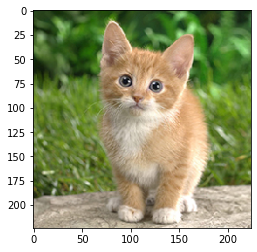

resnet18_v1 prediction
                     #1: umbrella
                     #2: tripod
                     #3: unicycle, monocycle
                     #4: typewriter keyboard
                     #5: turnstile
Performed inference in 2823.61ms/sample (std = 71.49)


In [7]:
# Download ImageNet categories
categ_url = "https://github.com/uwsaml/web-data/raw/master/vta/models/"
categ_fn = "synset.txt"
download.download(join(categ_url, categ_fn), categ_fn)
synset = eval(open(categ_fn).read())

# Download test image
image_url = 'https://homes.cs.washington.edu/~moreau/media/vta/cat.jpg'
response = requests.get(image_url)

# Prepare test image for inference
image = Image.open(BytesIO(response.content)).resize((224, 224))
plt.imshow(image)
plt.show()
image = np.array(image) - np.array([123., 117., 104.])
image /= np.array([58.395, 57.12, 57.375])
image = image.transpose((2, 0, 1))
image = image[np.newaxis, :]
image = np.repeat(image, env.BATCH, axis=0)

# Set the network parameters and inputs
m.set_input(**params)
m.set_input('data', image)

# Perform inference: we run the module 4 times,
# and repeat 3 times to get error bounds
timer = m.module.time_evaluator("run", ctx, number=4, repeat=3)
tcost = timer()

# Get classification results
tvm_output = m.get_output(0, tvm.nd.empty((env.BATCH, 1000), "float32", remote.cpu(0)))
top_categories = np.argsort(tvm_output.asnumpy()[0])

# Report top-5 classification results
std = np.std(tcost.results) * 1000 / env.BATCH
mean = tcost.mean * 1000 / env.BATCH
print("%s prediction" % model)
print("                     #1:", synset[top_categories[-1]])
print("                     #2:", synset[top_categories[-2]])
print("                     #3:", synset[top_categories[-3]])
print("                     #4:", synset[top_categories[-4]])
print("                     #5:", synset[top_categories[-5]])
print("Performed inference in %.2fms/sample (std = %.2f)" % (mean, std))


In [8]:
# Invoke the debug runtime to get a per-operator runtime breakdown
if env.TARGET == "sim":
    m.run()